## Diseño de un photon sieve con Diffractio

El objetivo es desarrollar un ejemplo en el cual se genere el photon sieve. El algoritmo inicial es de Javier Alda, pero lo he adaptado a python.

1. Generación de posiciones y radios
1. Creación de la máscara a partir de los datos de posiciones y radios
1. Determinacion de la distribución de intensidad en el punto focal
1. Obtención de parámetros del punto focal
1. Optimización

## Importación de módulos

In [2]:
from diffractio import np, sp, plt
from diffractio import mm, um, nm, degrees

from diffractio.scalar_masks_XY import Scalar_mask_XY

number of processors: 32
total memory        : 62.8 Gb
available memory    : 90 %
max frequency       : 3400 GHz


## Generación de las posiciones y radios

In [3]:
# Parámetros 
wavelength=0.6328*um
focal = 100*mm
r_min = 5*um

factor=1; # factor de desbordamiento de la zona por el agujero (busaremos un valro optimo en un paso posterior de optmización)
alpha0=0; # valor de la fase en posición para comenzar a colocar agujeros.


In [3]:
# a partir de estos valores se puede extraer el valor de la zona de Fresnel de mayor orden

jmax_rmin = np.floor( wavelength*focal/(8*r_min**2));

#corresponde al valor de separación entre agujeros (es una banda de seguridad para 
g=20*um; 

jmax_g = np.floor((wavelength*focal)/(4*g**2));

# es el mínimo entre los dos anteiores
jmax=min([jmax_rmin, jmax_g]) 



jmax=int(jmax)

print(jmax_rmin, jmax_g, jmax)


316.0 39.0 39


In [4]:
# una vez obtenido el valor del orden máximo de las zonas de fresnel
# ya podemos comenzar a generar los centros y los radios de esas zonas  
# zona 1es la zona más sencilla, corresponde a un solo agujero con tamaño igual ala primera zona

m0=1;
R=[np.sqrt(wavelength*focal),]
x=[0,]
y=[0,]

In [5]:
# zonas impares

#ii_impares=[3:2:jmax];
ii_impares=range(3,jmax,2)

In [6]:
r=[]
rho=[]
nn=[]
n=[]
resto=[]
deltaalfafinal=[]

alpha=[]
xzona=[]
yzona=[]

R_sieves=[]
x_sieves=[]
y_sieves=[]


In [7]:
x_sieves.append(0)
y_sieves.append(0)
R_sieves.append(np.sqrt(wavelength*focal))

In [8]:
for jj,__ in enumerate(ii_impares):
    # longitud de la lista de valores de radios, y posiciones de agujeros antes de empezar a calcular para la zona
    m0=len(R); 
    
    j=ii_impares[jj];
    
    r_new=factor*0.5*(np.sqrt(j+1)-np.sqrt(j))*np.sqrt(wavelength*focal); # radio del agujero;
    r.append(r_new)
    
    rho_new=0.5*(np.sqrt(j+1)+np.sqrt(j))*np.sqrt(wavelength*focal);
    rho.append(rho_new)
    
    deltaalfacong=2*np.arcsin( (r[jj]+g)/rho[jj]); # rango angular del agujero incluyendo la banda g
    
    # calculo del número de agujeros en cada zona de Fresnel
    nn_new=(2*np.pi)/(deltaalfacong);  # fraccion entre 2pi y lo que ocupa una zona
    nn.append(nn_new)
    
    n_new=int(np.floor(nn[jj]));  # numero de zonas (número entero)
    n.append(n_new)
    
    resto_new=np.mod(nn[jj],1);
    resto.append(resto_new)
    
    # deltaalfafinal[jj]=deltaalfacong+(nn[jj]/n[jj])-1;
    deltaalfafinal_new=deltaalfacong*(1+resto[jj]/n[jj]);
    deltaalfafinal.append(deltaalfafinal_new)

    
    for kk,_ in enumerate(range(n_new)):
        alpha_new=deltaalfafinal[jj]*kk+ alpha0 # posiciones angulares de los agujeros
        alpha.append(alpha_new)
        
        xzona_new=rho_new*np.sin(alpha_new)# posiciones x de los agujeros
        yzona_new=rho_new*np.cos(alpha_new) # posiciones x de los agujeros
        
        xzona.append(xzona_new)
        yzona.append(yzona_new)

        
        R_new=r_new
        R_sieves.append(R_new)
        x_sieves.append(xzona_new)
        y_sieves.append(yzona_new)

In [9]:
len(x_sieves),len(y_sieves), len(R_sieves)

(1819, 1819, 1819)

In [10]:
x_sieves=np.array(x_sieves)
y_sieves=np.array(y_sieves)
R_sieves=np.array(R_sieves)


## Creación de la máscara

In [11]:
x_max=x_sieves.max()+20*um
num_pixels=2048

x0=np.linspace(-x_max,x_max,num_pixels)
y0=np.linspace(-x_max,x_max,num_pixels)

In [12]:
ps0=Scalar_mask_XY(x0,y0,wavelength)
t_circle=Scalar_mask_XY(x0,y0,wavelength)
ps=Scalar_mask_XY(x0,y0,wavelength)

In [13]:
radii_u=np.unique(R_sieves)

In [14]:
%%time

for i,radius in enumerate(radii_u):
    i_radii = R_sieves==radius
    t_circle.clear_field()
    t_circle.circle(r0=(0,0),radius=radius)
    ps0.clear_field()
    xi=x_sieves[i_radii]
    yi=y_sieves[i_radii]
    r0=np.vstack((xi,yi))
    ps0.photon_sieve(t1=t_circle,r0=r0)
    ps=ps+ps0
    

(2, 159)
(2, 154)
(2, 148)
(2, 142)
(2, 135)
(2, 129)
(2, 122)
(2, 116)
(2, 109)
(2, 101)
(2, 94)
(2, 86)
(2, 78)
(2, 69)
(2, 60)
(2, 50)
(2, 39)
(2, 27)
(2, 1)
CPU times: user 15.6 s, sys: 4.11 s, total: 19.7 s
Wall time: 19.7 s


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7f766f2fbda0>)

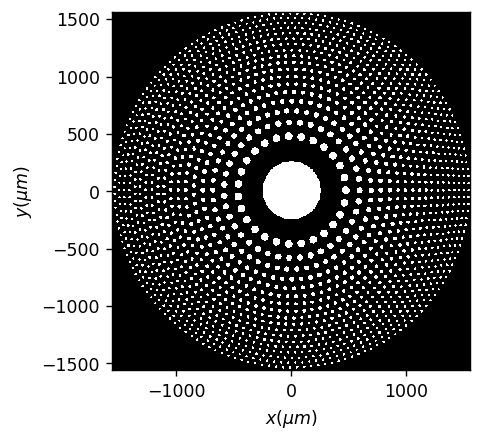

In [15]:
ps.draw(filename='ps_python.png');

In [16]:
ps.save_mask(filename='ps_python.bmp');

## Determinacion de la distribución de intensidad en el punto focal

In [17]:
%%time
u2=ps.RS(z=focal,verbose=True)

Good result: factor 13.22
CPU times: user 3.69 s, sys: 2.74 s, total: 6.44 s
Wall time: 3.55 s


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7f766f1f8e10>)

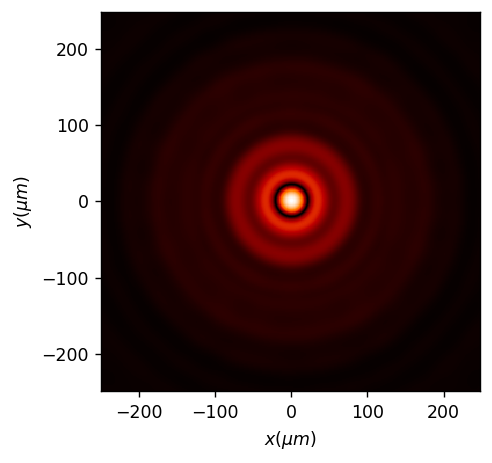

In [18]:
size=250
u3=u2.cut_resample(x_limits=(-size,size),y_limits=(-size,size), new_field=True)
u3.draw(logarithm=True,filename='ps_python_focus.png')

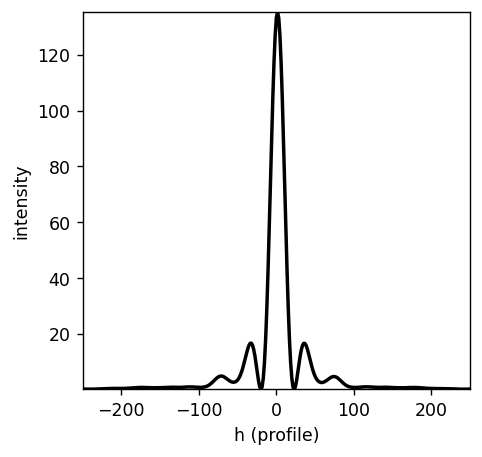

In [19]:
u3.draw_profile([-size,0], [size,0]);
plt.savefig('ps_python_profile.png')

## Obtención de parámetros del punto focal

## Optimización